# Range dependend frequency of outlier occurrence within different molecular subsets

### imports

In [1]:
import pickle
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from joblib import load

In [2]:
def count_occurrences_in_symmetric_ranges_summarized(
    df: pd.DataFrame, column_name: str, range_endpoints: List[float]
) -> Dict[Tuple[float, float], Dict[str, float]]:
    """
    Calculates the number of occurrences within symmetrically generated ranges
    around 0 in a DataFrame column, summarizing symmetric ranges and excluding (0,0).

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to analyze.
        range_endpoints (list of float): A list of *positive* range endpoints.
                                        Must be sorted in ascending order.

    Returns:
        dict: A dictionary where keys are the *positive* range endpoints (float)
              and values are the *sum* of counts for the corresponding
              symmetric ranges. Returns an empty dictionary if the column
              does not exist.
    """
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return {}

    counts: Dict[Tuple[float, float], Dict[str, float]] = {}
    previous_endpoint = 0.0  # Start with 0 as the initial lower bound

    for endpoint in range_endpoints:
        if endpoint != 0.0:  # Exclude (0,0) equivalent
            lower_bound_neg = -endpoint
            upper_bound_neg = -previous_endpoint
            lower_bound_pos = previous_endpoint
            upper_bound_pos = endpoint

            count_neg = df[column_name].between(
                lower_bound_neg, upper_bound_neg, inclusive="both"
            ).sum()
            count_pos = df[column_name].between(
                lower_bound_pos, upper_bound_pos, inclusive="both"
            ).sum()
            total_count = count_neg + count_pos

            percentage = (total_count / len(df)) * 100

            counts[(lower_bound_pos, upper_bound_pos)] = {
                "count": total_count,
                "percentage": percentage,
            }

        previous_endpoint = endpoint  # Update previous endpoint for the next iteration

    return counts

### functions

In [3]:
def separate_counts_and_percentages(
    data_dict: Dict[str, Dict[Tuple[float, float], Dict[str, float]]]
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Separates a dictionary with tuple keys and dictionaries as values
    (containing 'count' and 'percentage') into two DataFrames.

    Args:
        data_dict (dict): The input dictionary.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
               (counts_df, percentages_df).
               Returns (None, None) if the input is not in the expected format
               or if the input dictionary is empty.
    """

    if not isinstance(data_dict, dict) or not data_dict:
        return pd.DataFrame(), pd.DataFrame()

    counts_data: Dict[str, Dict[Tuple[float, float], int]] = {}
    percentages_data: Dict[str, Dict[Tuple[float, float], float]] = {}

    for feature, ranges_dict in data_dict.items():
        feature_counts: Dict[Tuple[float, float], int] = {}
        feature_percentages: Dict[Tuple[float, float], float] = {}
        for range_tuple, metrics in ranges_dict.items():
            if isinstance(metrics, dict) and "count" in metrics and "percentage" in metrics:
                feature_counts[range_tuple] = int(metrics["count"])
                feature_percentages[range_tuple] = float(metrics["percentage"])
            else:
                return pd.DataFrame(), pd.DataFrame()

        counts_data[feature] = feature_counts
        percentages_data[feature] = feature_percentages

    counts_df = pd.DataFrame.from_dict(counts_data, orient="columns")
    percentages_df = pd.DataFrame.from_dict(percentages_data, orient="columns")

    return counts_df, percentages_df

### main code

In [ ]:
def main():
    """
    Analyzes the outlier occurrence frequency within molecular subsets based on
    predicted GAP values and descriptor ranges.
    """
    try:
        X = pd.read_pickle("data/processed/calc_descriptors_final.pkl")
    except FileNotFoundError:
        print("Error: 'data/processed/calc_descriptors_final.pkl' not found.")
        return

    scaler = MinMaxScaler()
    X["Ipc"] = scaler.fit_transform(X["Ipc"].values.reshape(-1, 1))

    scaler = StandardScaler().fit(X)
    scaled = scaler.transform(X)

    try:
        df = pd.read_pickle("data/processed/gap_smile.pkl")
    except FileNotFoundError:
        print("Error: 'data/processed/gap_smile.pkl' not found.")
        return

    y = df["GAP"].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(
        scaled, y, test_size=0.3, random_state=42
    )
    try:
        reg = load("data/processed/reg_NN_MLP.joblib")
    except FileNotFoundError:
        print("Error: 'data/processed/reg_NN_MLP.joblib' not found.")
        return

    gap_pred = reg.predict(scaled)
    df["GAP_P"] = gap_pred
    df_concat = pd.concat([df, X], axis=1, join="inner")
    df_concat["diff"] = df_concat["GAP"] - df_concat["GAP_P"]

    gap_ranges = [0.0, 0.1, 0.2, 0.4, 0.8, 1.2, 2.0, 10.0]
    results_abs: Dict[str, Dict[Tuple[float, float], Dict[str, float]]] = {}

    for descr in df_concat.columns:
        if any(sub in descr for sub in ["Num", "fr"]) and "NumRadicalElectrons" not in descr:
            filtered_df = df_concat[df_concat[descr] > 1]
            outliers_abs = count_occurrences_in_symmetric_ranges_summarized(
                filtered_df, "diff", gap_ranges
            )
            results_abs[descr] = outliers_abs

    count_df, percentage_df = separate_counts_and_percentages(results_abs)

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        percentage_df,
        annot=count_df,
        vmin=0,
        vmax=50,
        cmap="viridis",
        fmt="5g",
        norm=LogNorm(),
    )
    plt.ylabel("GAP ranges")
    plt.yticks(rotation=30)
    plt.title("Outliers resolved by subsets")
    plt.tight_layout()
    plt.savefig("gap_range_vs_descriptor_outliers.png")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        percentage_df,
        annot=percentage_df,
        vmin=0,
        vmax=50,
        cmap="viridis",
        fmt=".1f",
        norm=LogNorm(),
    )
    plt.ylabel("GAP ranges")
    plt.yticks(rotation=30)
    plt.title("Outliers resolved by subsets (Percentage)")
    plt.tight_layout()
    plt.savefig("gap_range_vs_descriptor_outliers_percentage.png")
    plt.show()

/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


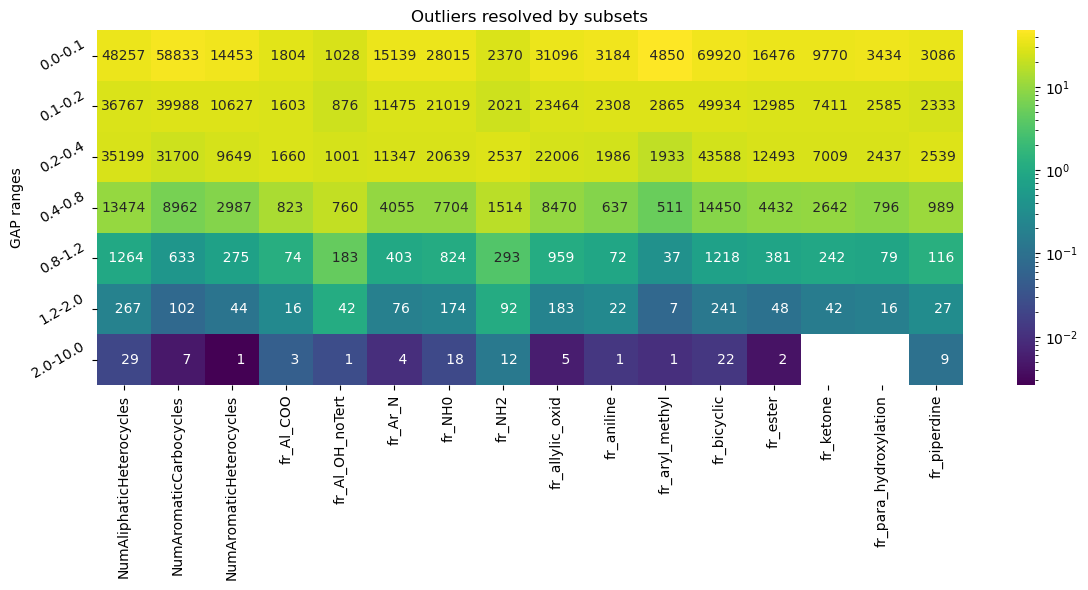

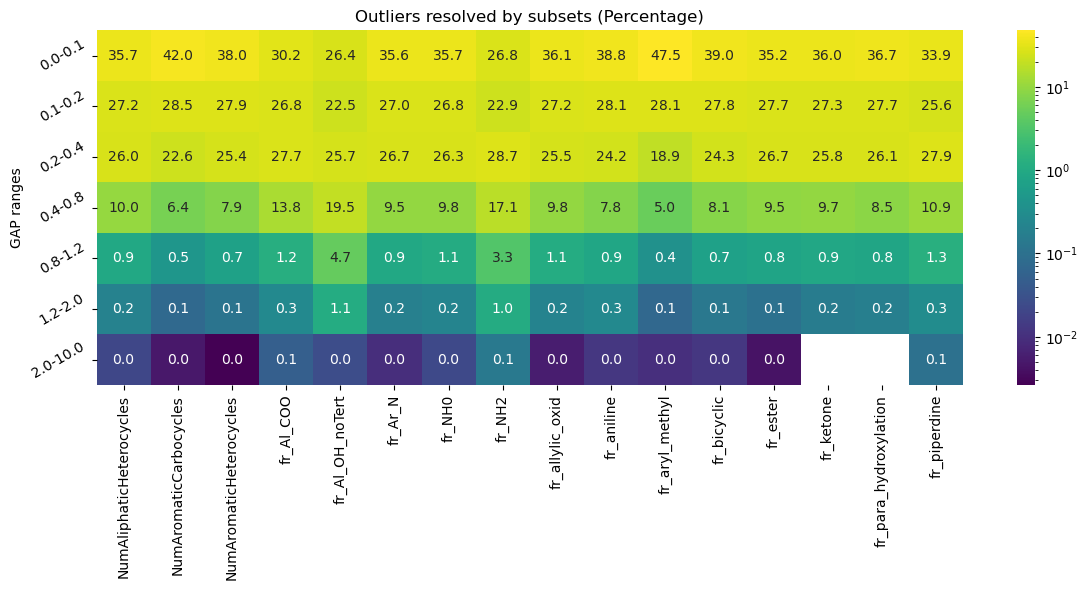

In [5]:
if __name__ == "__main__":
    main()